<a href="https://colab.research.google.com/github/leunseo/Deep_Learning_PROJECT/blob/main/Final_Project23.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import nltk
from nltk.corpus import stopwords
import string
from nltk.stem import WordNetLemmatizer
import re

from collections import Counter
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from keras.models import Sequential
from keras.layers import  Input
from keras.layers import Dense
from keras.layers import LSTM, GRU, SimpleRNN
from keras.layers import Embedding

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.pipeline import Pipeline

from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [2]:
#import data
mail = pd.read_csv("/content/df.csv", encoding="latin-1", usecols=["v1", "v2"])
mail = mail.copy()
mail.columns = ["label", "text"]
mail = mail[["text", "label"]]
mail["label"] = mail["label"].map({"ham": 0, "spam": 1}) #spam:1, ham:0
mail.head()

,text,label
0,"Go until jurong point, crazy.. Available only ...",0
1,Ok lar... Joking wif u oni...,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,U dun say so early hor... U c already then say...,0
4,"Nah I don't think he goes to usf, he lives aro...",0


In [3]:
#Checking for misssing values
mail.isnull().sum()

text     0
label    0
dtype: int64

In [4]:
#Finding duplicate and Removing duplicate
mail.duplicated().sum() #403
mail = mail.drop_duplicates(keep='first')

#Result after removing duplicate
mail.duplicated().sum() #0

0

In [5]:
mail['label'].value_counts() #Number of spam: 653, Number of ham:4516

0    4516
1     653
Name: label, dtype: int64

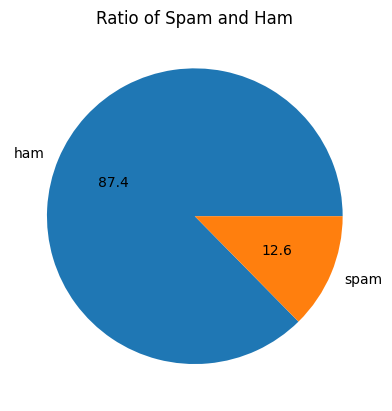

In [6]:
#Check data imbalances
from matplotlib import pyplot as plt

plt.pie(mail['label'].value_counts(), labels=['ham','spam'],autopct="%0.1f")
plt.title('Ratio of Spam and Ham')
plt.show()

In [7]:
mail['length'] = mail['text'].apply(len)
mail.head()

,text,label,length
0,"Go until jurong point, crazy.. Available only ...",0,111
1,Ok lar... Joking wif u oni...,0,29
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,155
3,U dun say so early hor... U c already then say...,0,49
4,"Nah I don't think he goes to usf, he lives aro...",0,61


Text(0.5, 1.0, 'Length of Text')

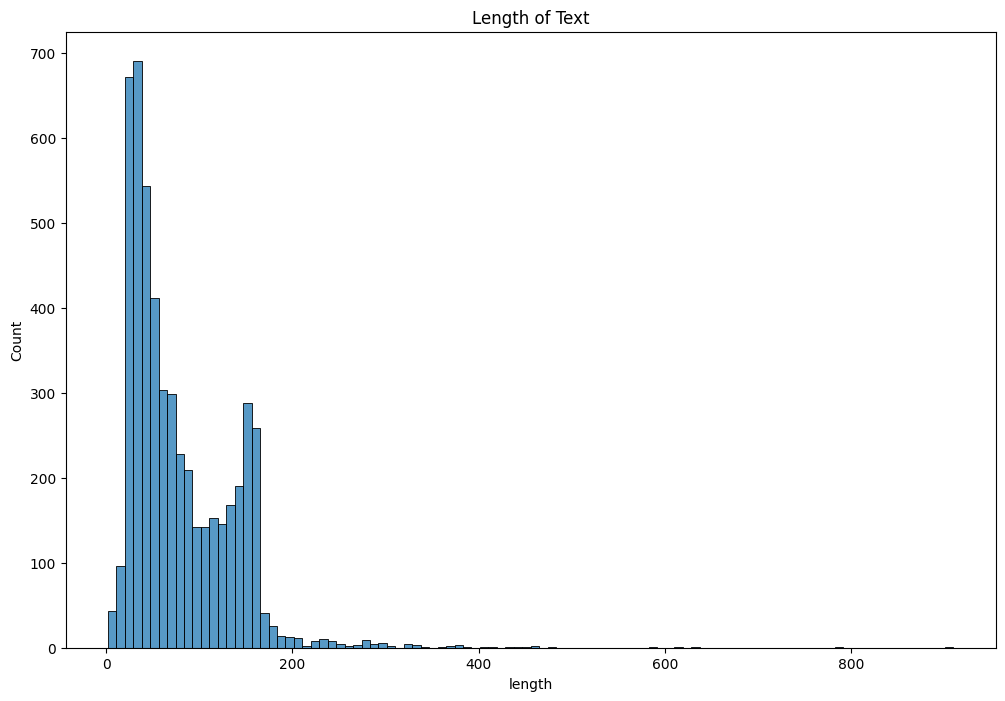

In [8]:
plt.figure(figsize=(12,8))
sns.histplot(x='length', data=mail, bins=100)
plt.title('Length of Text')

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

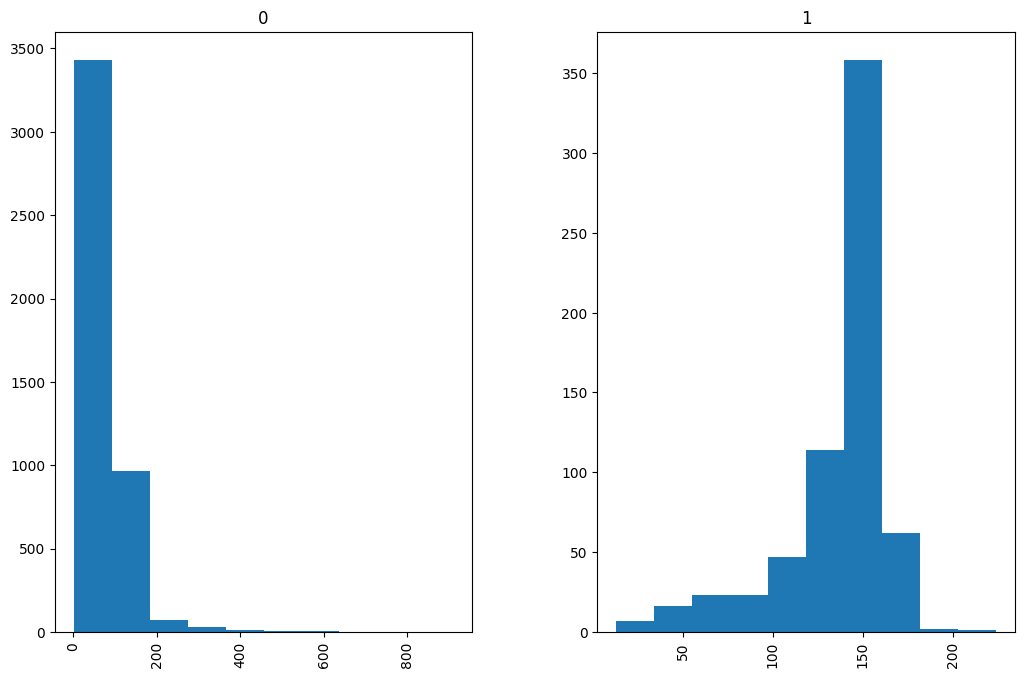

In [9]:
# distribution of spam and ham by length of text
mail.hist(column='length',by='label',figsize=(12,8))

In [10]:
# function to remove punctuation and stopwords
def text_process(text):
    non_punc = [char for char in text if char not in string.punctuation]
    non_punc=''.join(non_punc)
    return [word for word in non_punc.split() if word not in stopwords.words('english')]

In [11]:
# define X(features), y(target)
X = mail['text']
y = mail['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [12]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
#Creating new Feature

#1. 'num_of_Character'
mail['num_of_character'] =mail['text'].apply(len)

#2. 'num of words'
mail['num_word'] = mail['text'].apply(lambda x:len(nltk.word_tokenize(x)))

#3. 'num_sentences'
mail['num_sentence'] = mail['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [14]:
mail[['num_of_character','num_word','num_sentence']].describe()

,num_of_character,num_word,num_sentence
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [15]:
#Analysis where label == 0 (ham)
mail[mail['label'] == 0][['num_of_character','num_word','num_sentence']].describe()

,num_of_character,num_word,num_sentence
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [16]:
#Analysis where label == 1(spam)
mail[mail['label'] ==1][['num_of_character','num_word','num_sentence']].describe()

,num_of_character,num_word,num_sentence
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


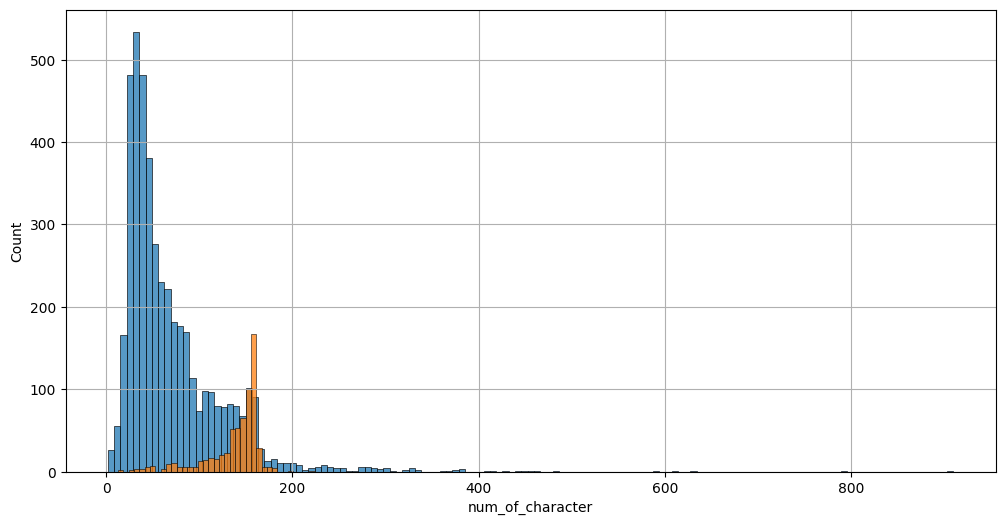

In [17]:
#Now see these conclusions by graphically
import seaborn as sns
plt.figure(figsize=(12,6))
sns.histplot(mail[mail['label'] == 0]['num_of_character'])
sns.histplot(mail[mail['label'] == 1]['num_of_character'])
plt.grid()

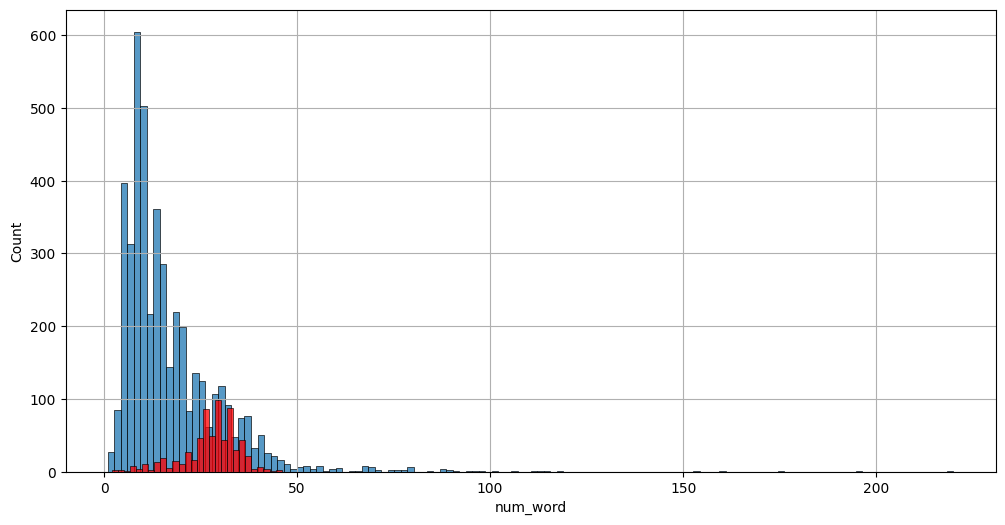

In [18]:
plt.figure(figsize=(12,6))
sns.histplot(mail[mail['label'] == 0]['num_word'])
sns.histplot(mail[mail['label'] == 1]['num_word'],color='red')
plt.grid()

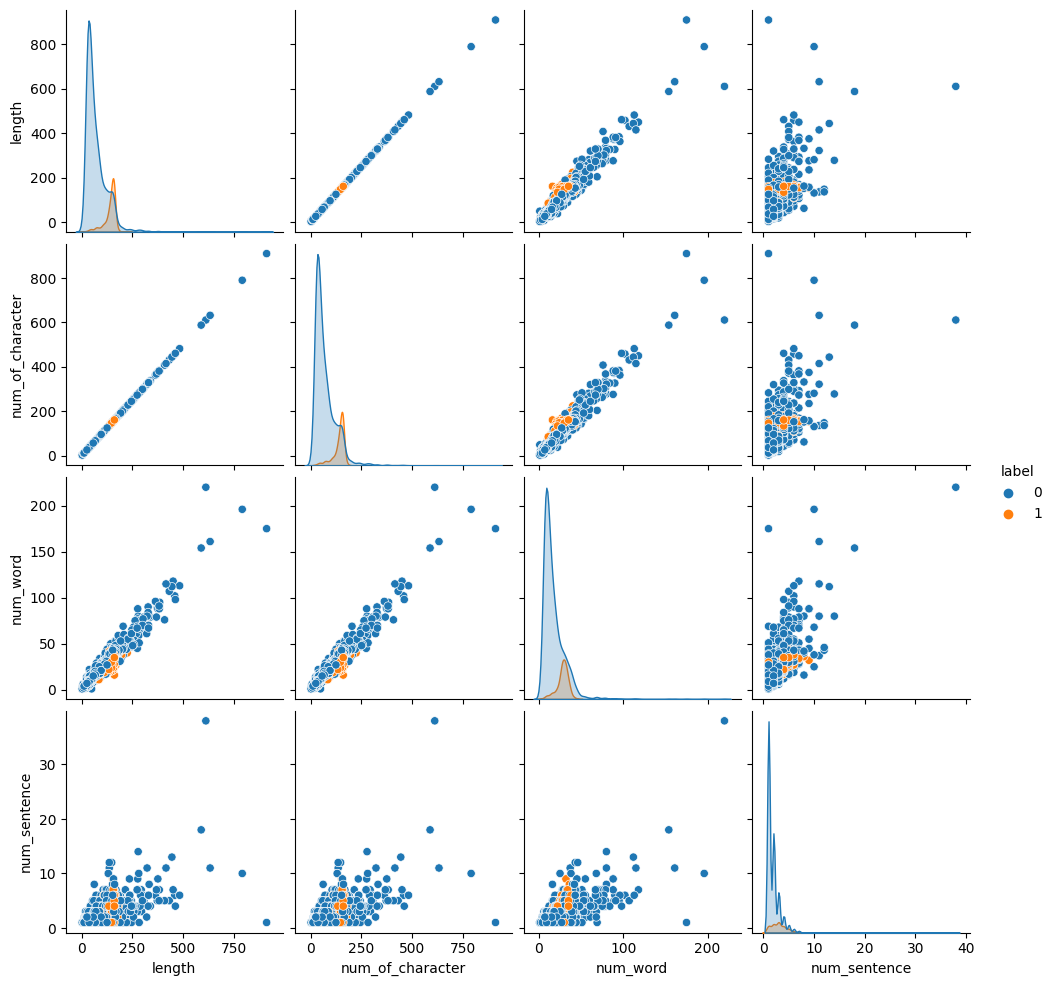

In [19]:
sns.pairplot(mail ,hue='label')
plt.grid()

<Axes: >

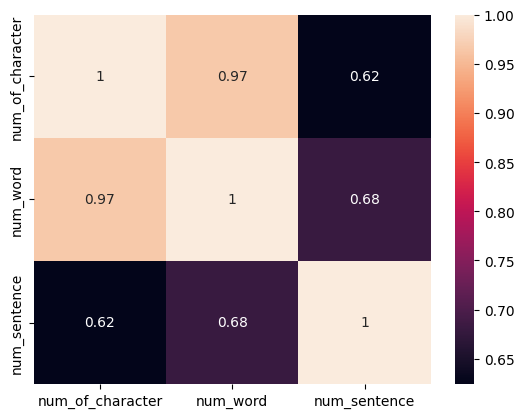

In [20]:
sns.heatmap(mail[['num_of_character','num_word','num_sentence']].corr(),annot=True)

In [21]:
#Define fuction 'Word Frenqeuncy'

def word_freq(data, label, text, title):
    freq_df = data[data["label"] == label]
    freq_words = freq_df[text].tolist()
    freq_words = [i.lower() for i in freq_words]
    freq_punc = []

    for o in freq_words:
        freq_punc += nltk.word_tokenize(o)

    freq_punc = [o for o in freq_punc if o not in string.punctuation]
    freq_freq = Counter(freq_punc)

    freq_top = freq_freq.most_common(50)

    words = [word for word, _ in freq_top]
    counts = [count for _, count in freq_top]

    plt.figure(figsize=(15, 25))
    plt.barh(words, counts)
    plt.title(title)
    plt.xlabel("Frequency")
    plt.ylabel("Words")

    return freq_top

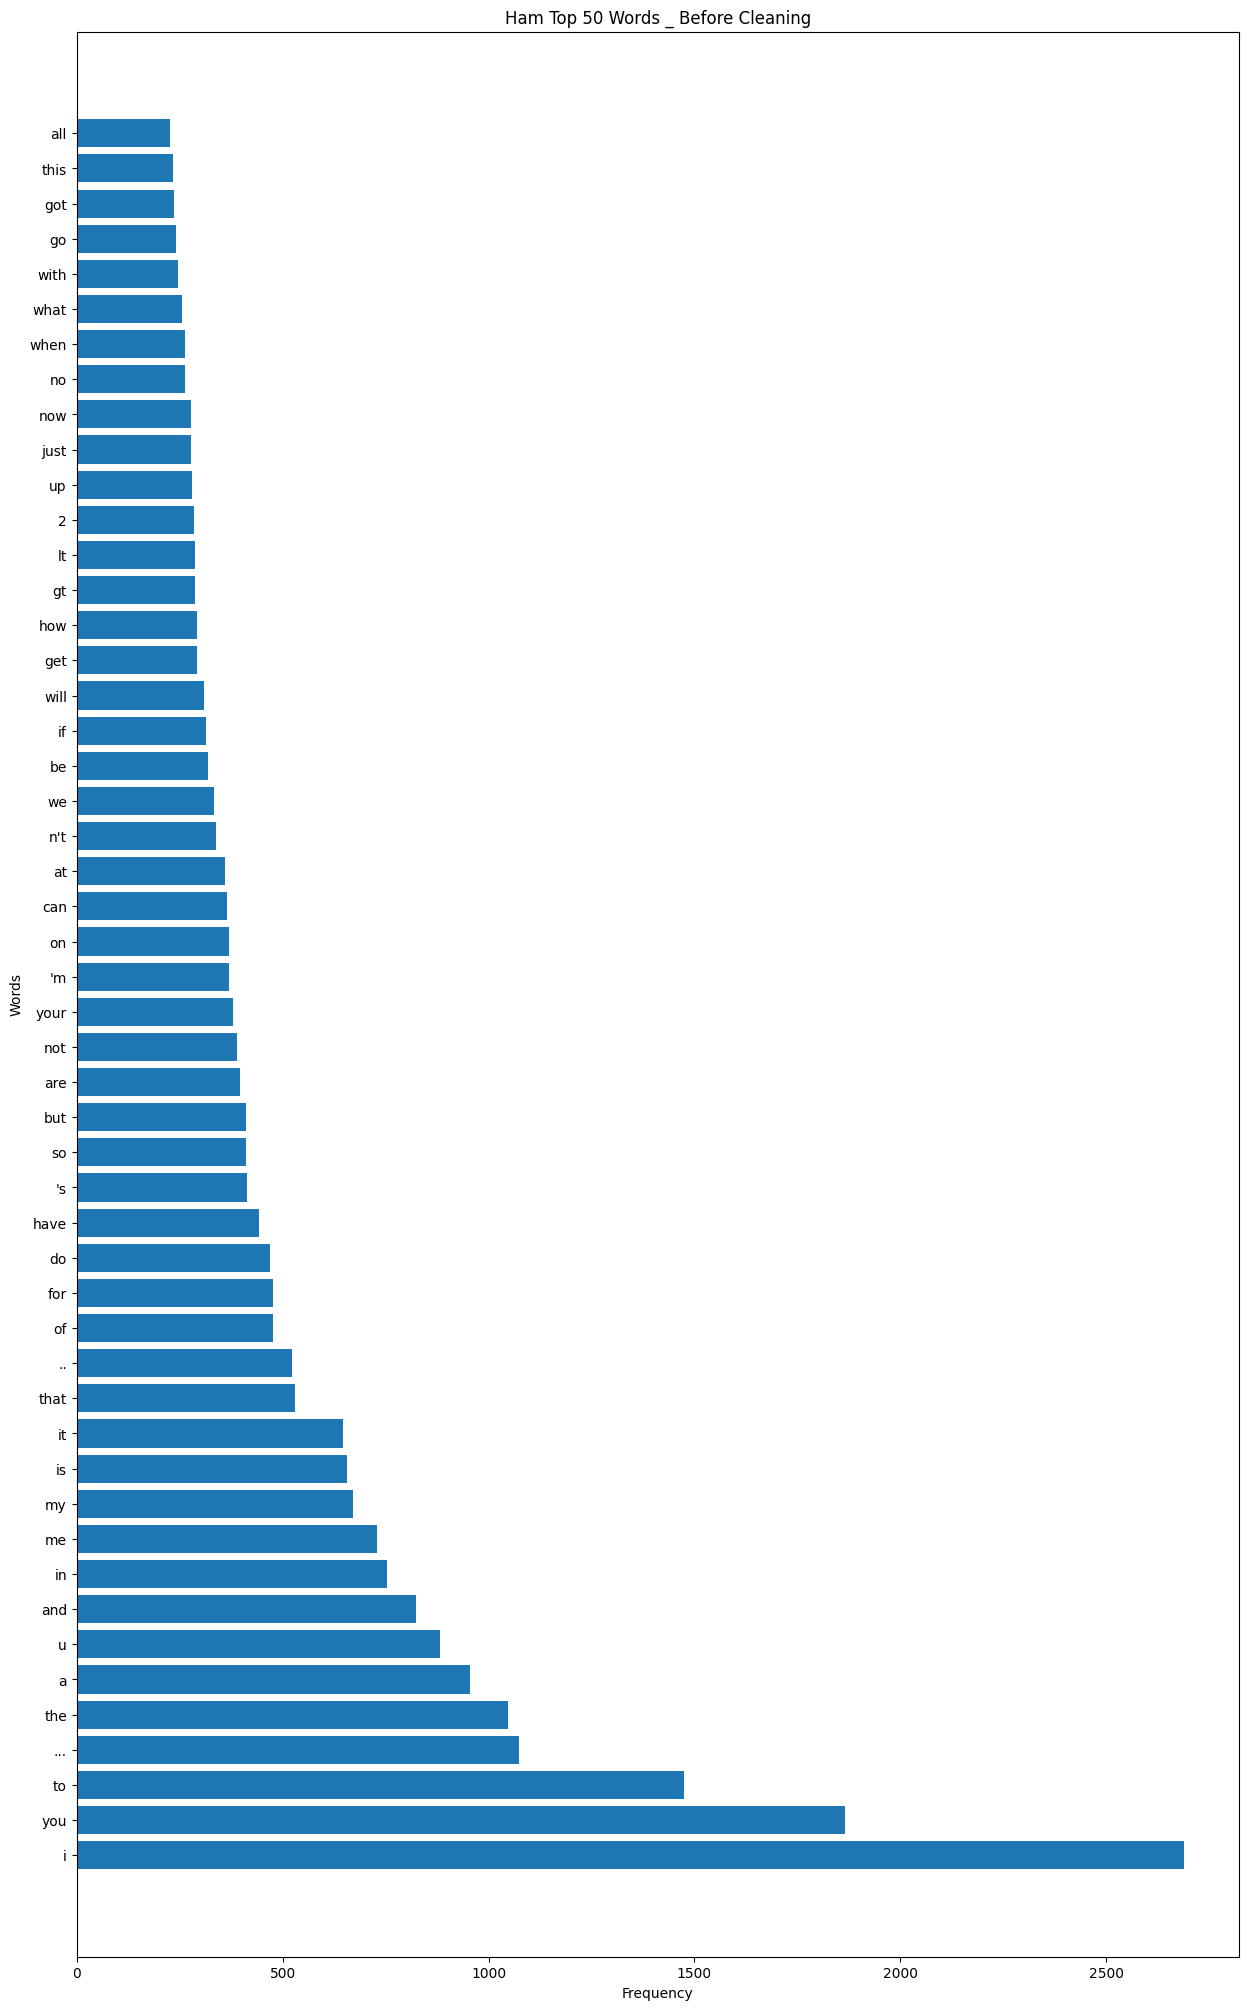

In [22]:
ham_freq_top = word_freq(mail, 0, "text", "Ham Top 50 Words _ Before Cleaning")

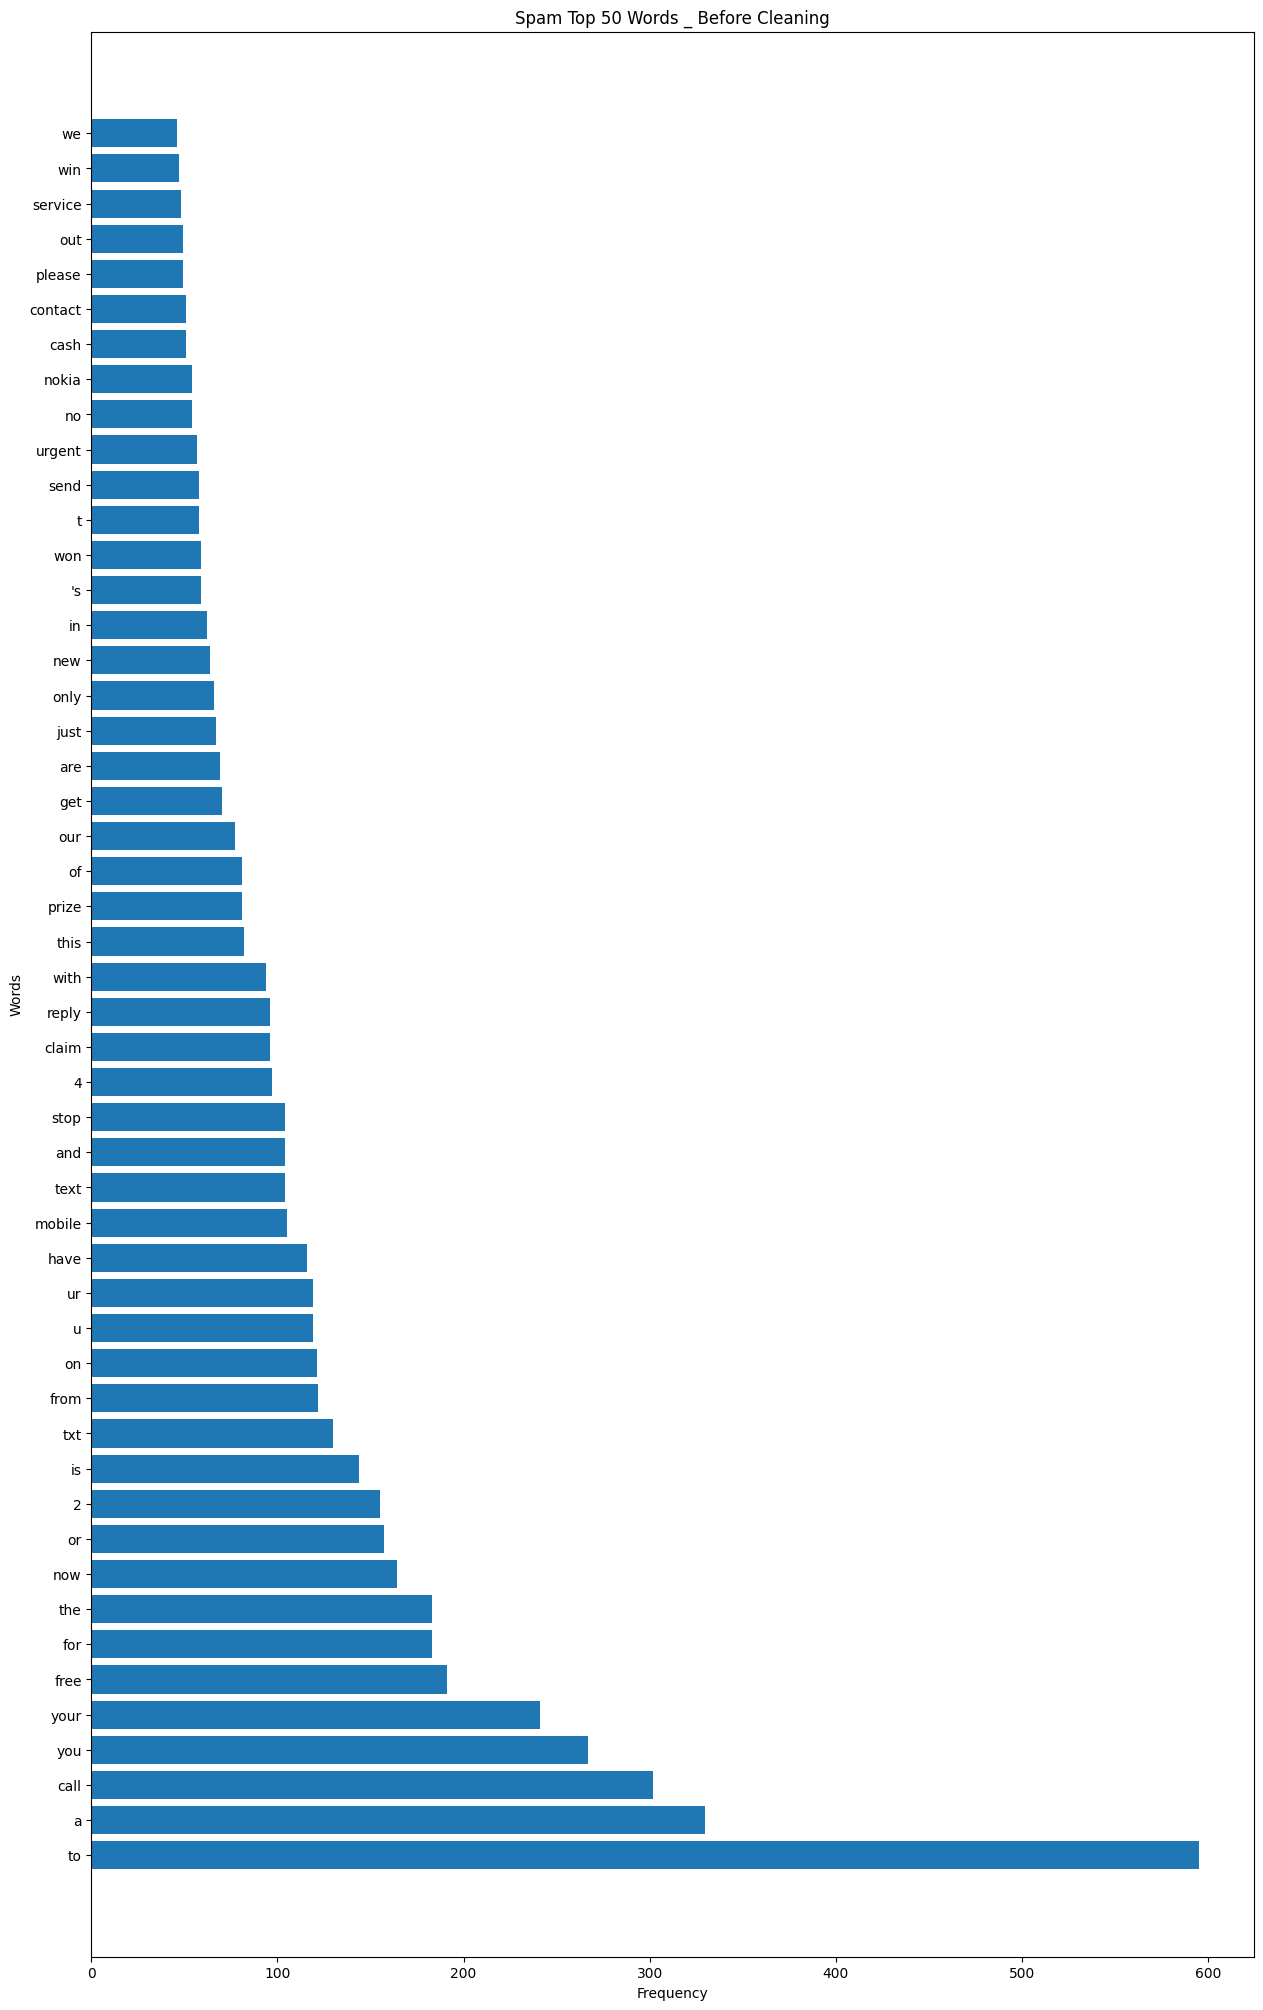

In [23]:
spam_freq_top = word_freq(mail, 1, "text", "Spam Top 50 Words _ Before Cleaning")

In [24]:
def print_wordcloud(freq_top):
    dict_top = dict(freq_top)
    wordcloud = WordCloud(width=700, height=350, background_color="black", min_font_size=5).generate_from_frequencies(dict_top)
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")

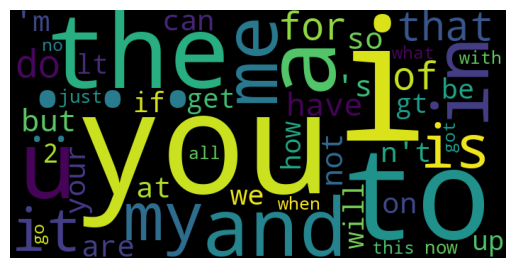

In [25]:
print_wordcloud (ham_freq_top)

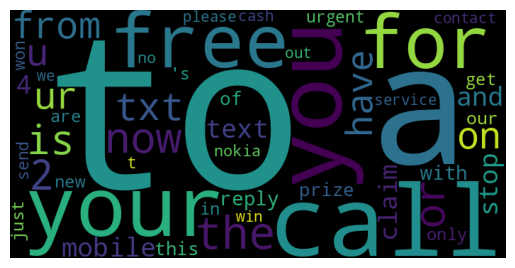

In [26]:
print_wordcloud(spam_freq_top)

In [27]:
#Data Preprocessing
stop_words = set(stopwords.words("english"))

In [28]:
smart_words = '/content/SmartStoplist.txt'

In [29]:
smart_stoplist = []

In [30]:
for line in open(smart_words, "r"):
    if line.strip()[0:1] != "#":
        for word in line.split():
            smart_stoplist.append(word)

In [31]:
smart_stoplist

['a',
 "a's",
 'able',
 'about',
 'above',
 'according',
 'accordingly',
 'across',
 'actually',
 'after',
 'afterwards',
 'again',
 'against',
 "ain't",
 'all',
 'allow',
 'allows',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'an',
 'and',
 'another',
 'any',
 'anybody',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anyways',
 'anywhere',
 'apart',
 'appear',
 'appreciate',
 'appropriate',
 'are',
 "aren't",
 'around',
 'as',
 'aside',
 'ask',
 'asking',
 'associated',
 'at',
 'available',
 'away',
 'awfully',
 'b',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'believe',
 'below',
 'beside',
 'besides',
 'best',
 'better',
 'between',
 'beyond',
 'both',
 'brief',
 'but',
 'by',
 'c',
 "c'mon",
 "c's",
 'came',
 'can',
 "can't",
 'cannot',
 'cant',
 'cause',
 'causes',
 'certain',
 'certainly',
 'changes',
 'clearly',
 'co',
 'com',
 'come',
 'c

In [32]:
smart_stoplist.append("_")

In [33]:
nltk.download("all")

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

In [34]:
!ls -l ~/nltk_data/

total 40
drwxr-xr-x  3 root root 4096 Dec  8 15:12 chunkers
drwxr-xr-x 74 root root 4096 Dec  8 15:13 corpora
drwxr-xr-x  7 root root 4096 Dec  8 15:13 grammars
drwxr-xr-x  3 root root 4096 Dec  8 15:13 help
drwxr-xr-x  4 root root 4096 Dec  8 15:12 misc
drwxr-xr-x  6 root root 4096 Dec  8 15:13 models
drwxr-xr-x  2 root root 4096 Dec  8 15:13 sentiment
drwxr-xr-x  4 root root 4096 Dec  8 15:13 stemmers
drwxr-xr-x  6 root root 4096 Dec  8 15:13 taggers
drwxr-xr-x  3 root root 4096 Dec  8 15:11 tokenizers


In [35]:
import nltk
nltk.download("stopwords")
nltk.download("wordnet")

def clean(text):
    text = re.sub(r'Subject: re :.*subject : re : ', '', text, flags=re.IGNORECASE)
    text = re.sub("Subject:", "", text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r"[^\w\s]", "", text)
    text = text.lower()
    text = re.sub(r"\d+", "", text)

    text = " ".join([word for word in text.split() if word not in smart_stoplist])

    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    text = text.strip()
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [36]:
mail["clean"] = mail["text"].apply(clean)

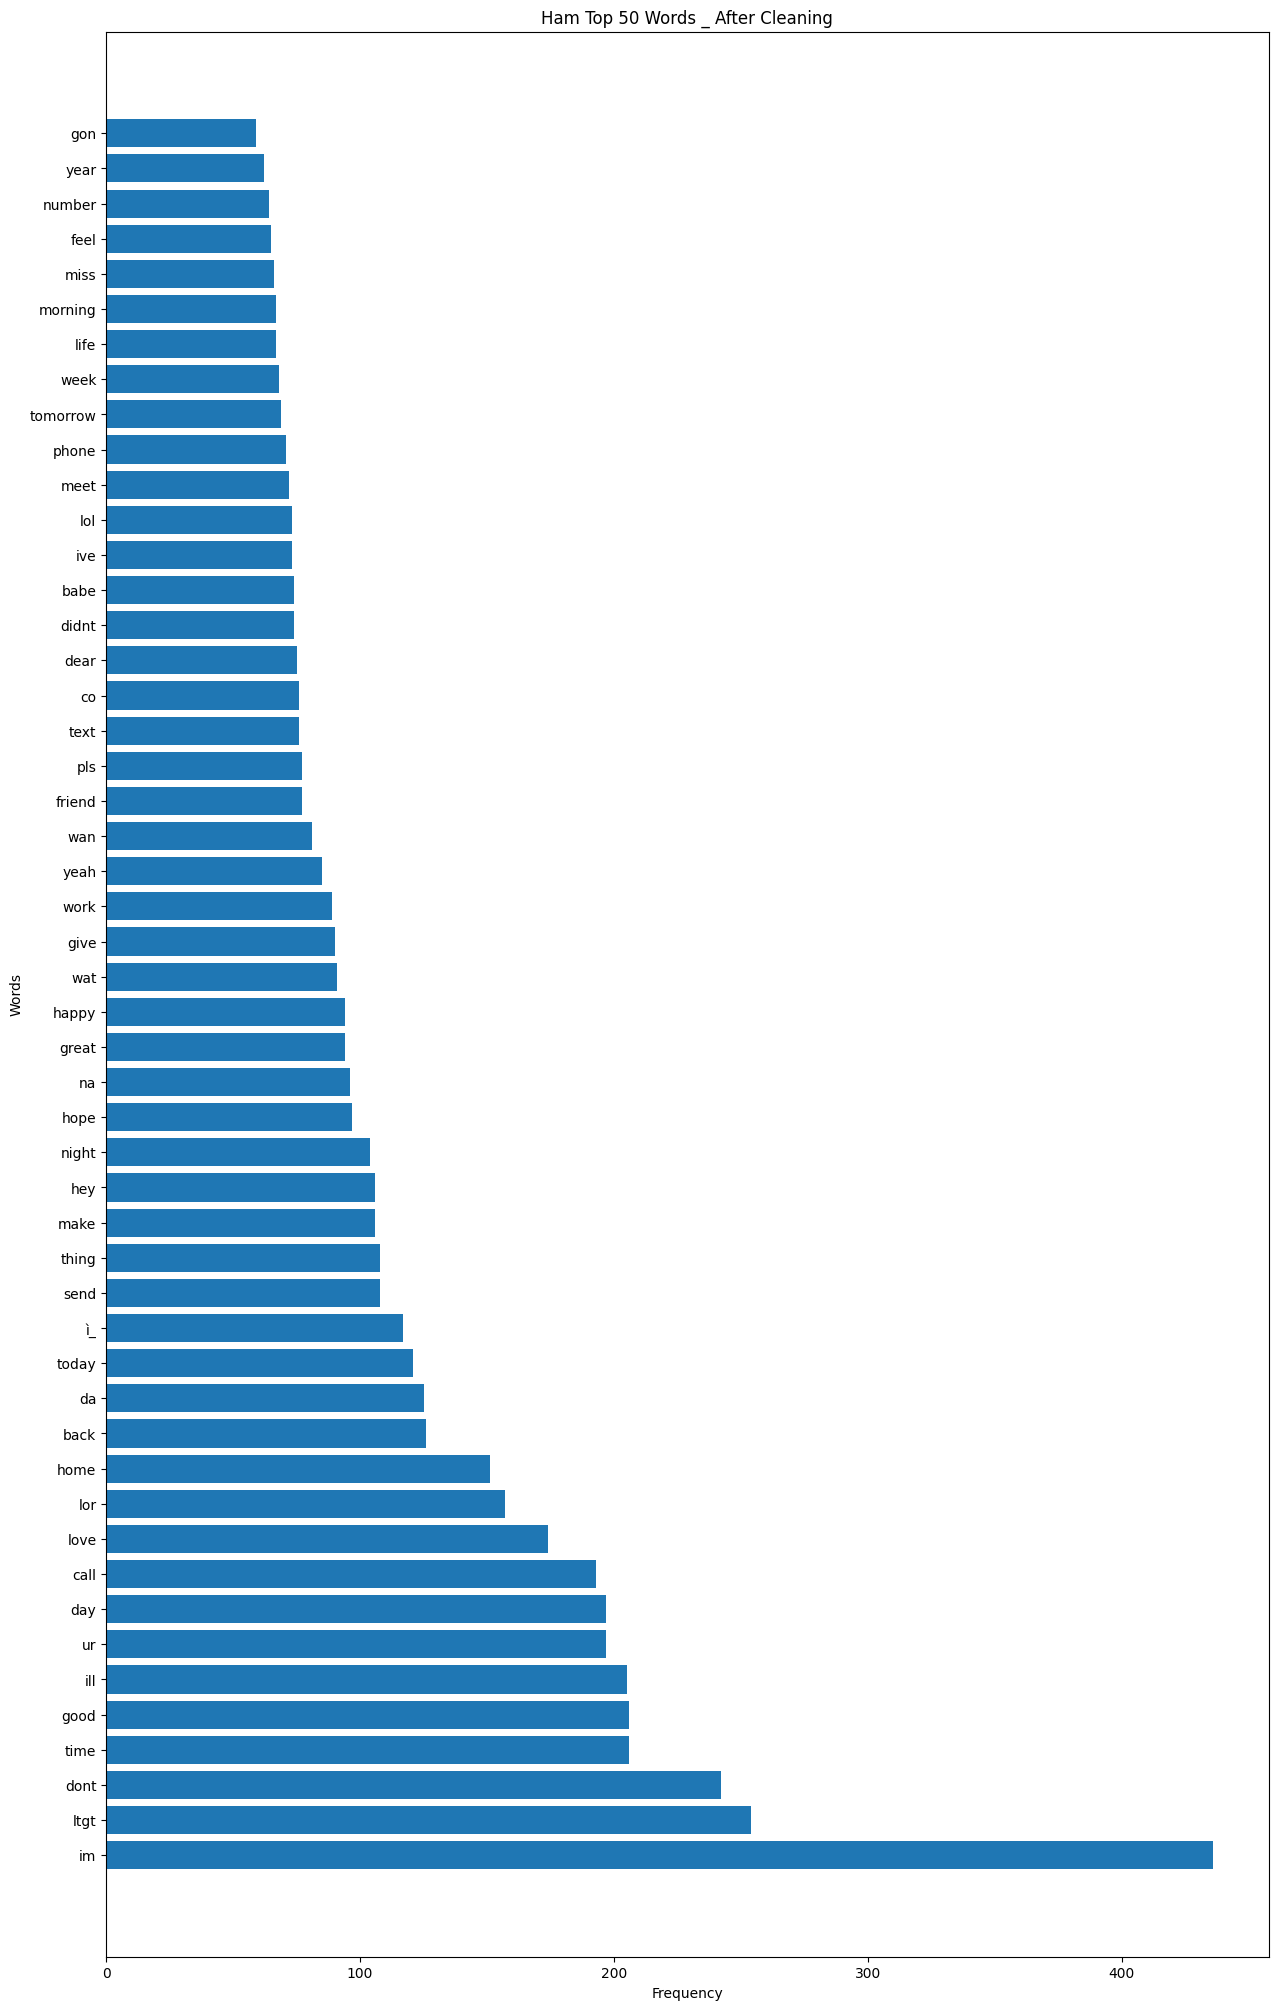

In [37]:
clean_ham_freq_top = word_freq(mail, 0, "clean", "Ham Top 50 Words _ After Cleaning")

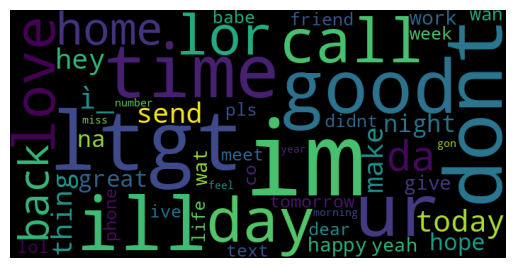

In [38]:
print_wordcloud(clean_ham_freq_top)

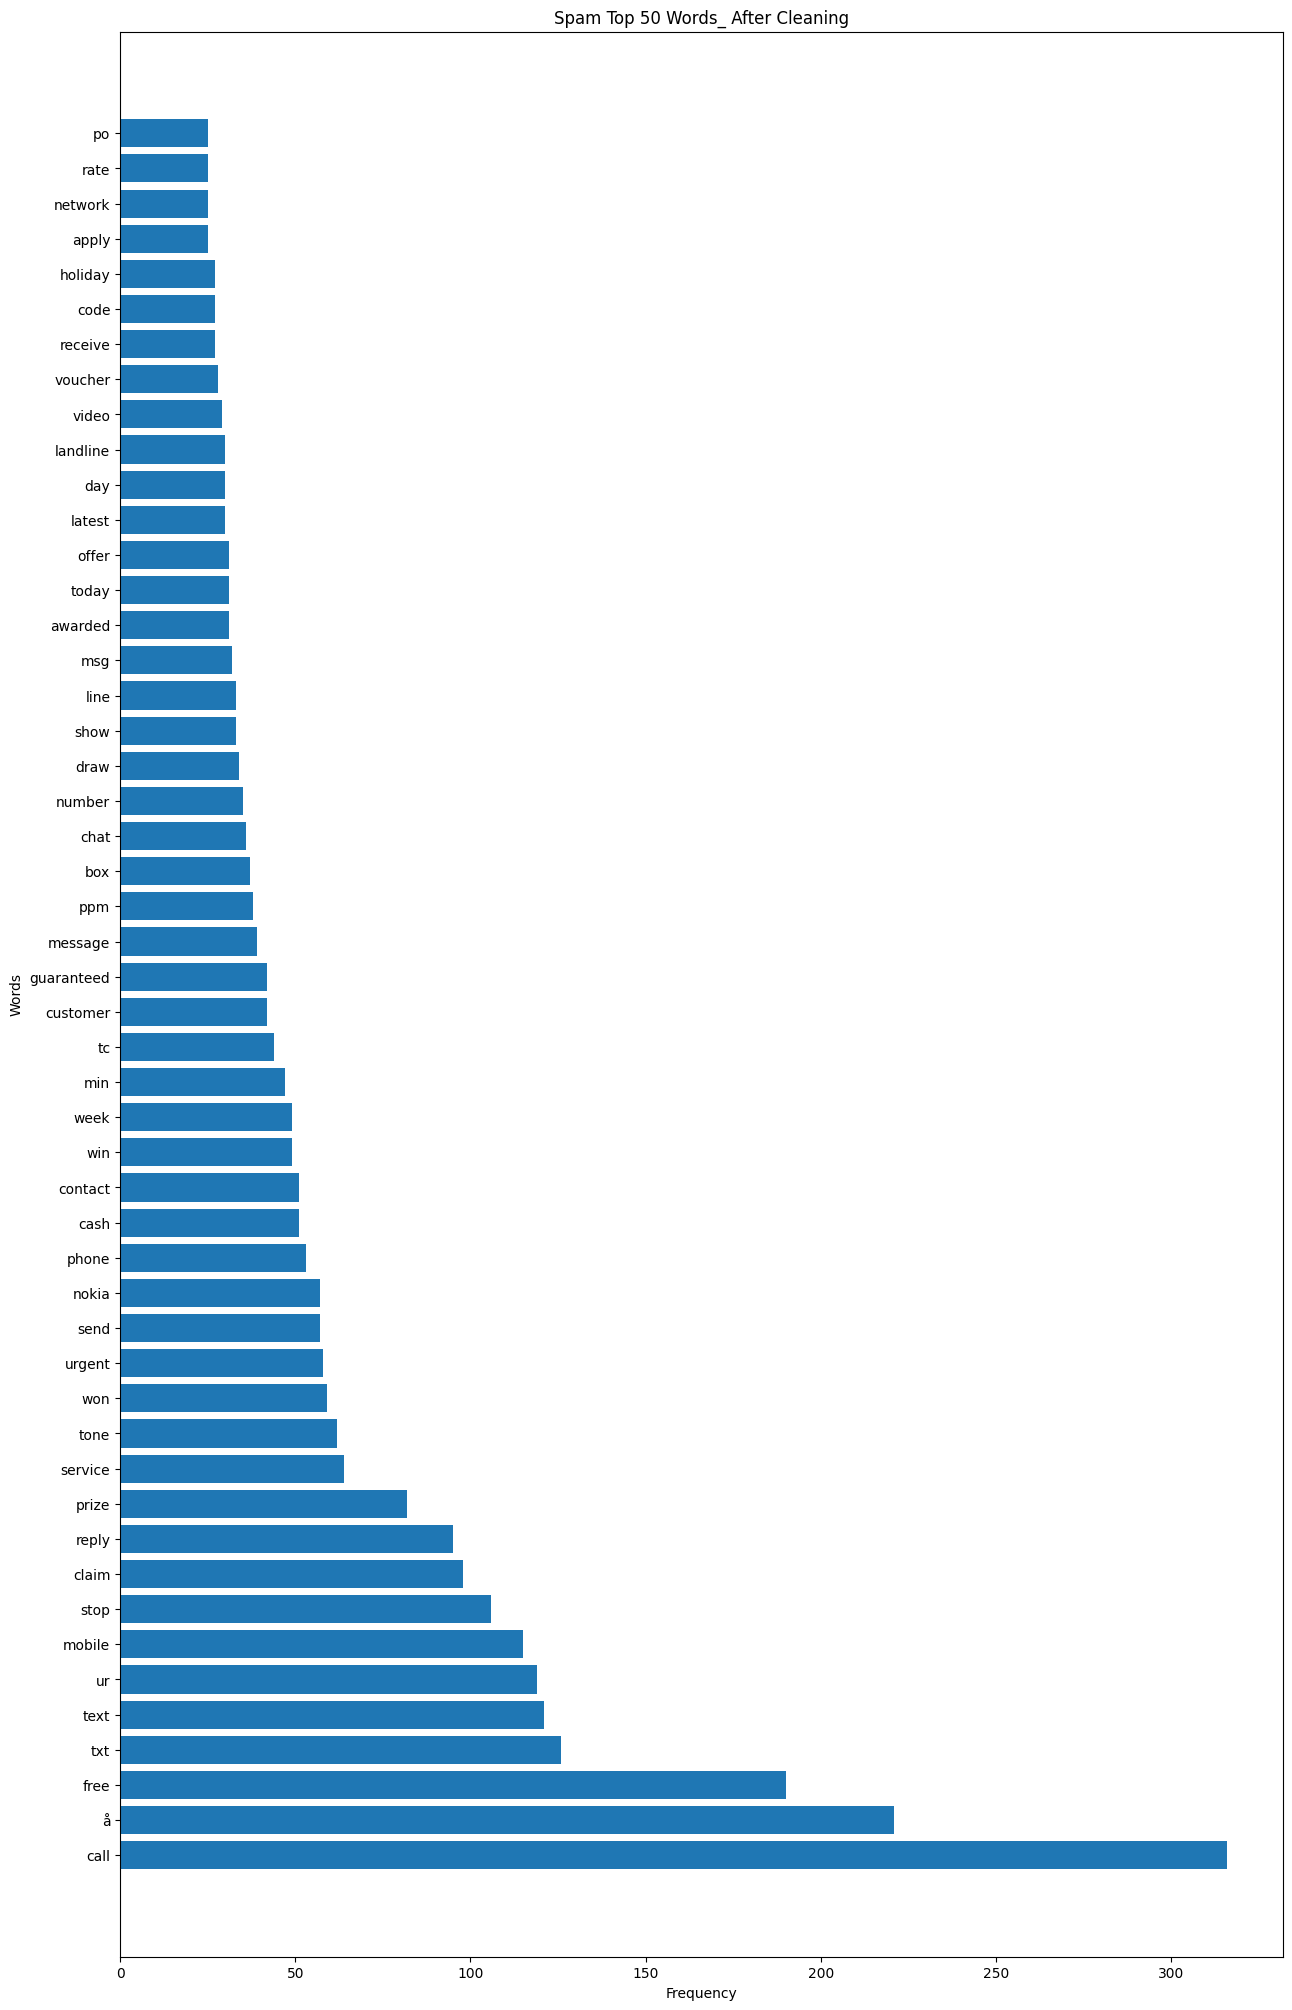

In [39]:
clean_spam_freq_top = word_freq(mail, 1, "clean", "Spam Top 50 Words_ After Cleaning")

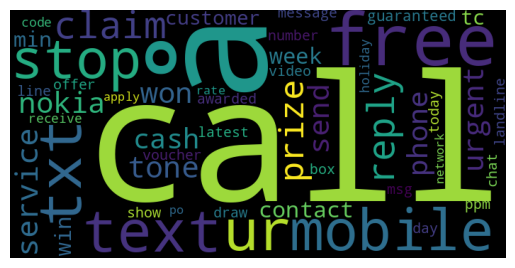

In [40]:
print_wordcloud(clean_spam_freq_top)

In [41]:
#Feature Scaling
X = mail["clean"]
y = mail["label"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

maxlen = 150

from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=400000,
    filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower = True,
    split = " ")
tokenizer.fit_on_texts(X)

In [42]:
word_index = tokenizer.word_index
len(word_index)

7643

In [44]:
X_train_tokenizer = tokenizer.texts_to_sequences(X_train)
X_train_tokenizer = pad_sequences(X_train_tokenizer, maxlen=maxlen)

X_test_tokenizer = tokenizer.texts_to_sequences(X_test)
X_test_tokenizer = pad_sequences(X_test_tokenizer, maxlen=maxlen)

In [45]:
input_dim = len(tokenizer.word_index) + 1
input_dim

7644

In [149]:
embeddings_index = {}
df = open("/content/glove.6B.300d.txt", "r", encoding="latin-1")
for line in tqdm.tqdm(df):
    values = line.split(" ")
    word = values[0]
    coefs = np.asarray([float(val) for val in values[1:]])
    embeddings_index[word] = coefs

df.close()
print("Found %s word vectors." % len(embeddings_index))

3227it [00:00, 3954.64it/s]

Found 3227 word vectors.


In [150]:
import tqdm

embedding_matrix = np.zeros((input_dim, 300))
for word, i in tqdm.tqdm(tokenizer.word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

100%|██████████| 7643/7643 [00:00<00:00, 417801.40it/s]


In [151]:
## MODEL
## SIMPLE_RNN
simplernn = Sequential([
    Input(shape=X_train_tokenizer.shape[1]),
    Embedding(len(tokenizer.word_index)+1, 32),
    SimpleRNN(100),
    Dense(1, activation='sigmoid')
])

simplernn.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

simplernn.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 150, 32)           244608    
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 100)               13300     
                                                                 
 dense_9 (Dense)             (None, 1)                 101       
                                                                 
Total params: 258009 (1007.85 KB)
Trainable params: 258009 (1007.85 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [152]:
model1_train_start = time.time()
simplernn_history = simplernn.fit(X_train_tokenizer, y_train, epochs=4, batch_size=64,validation_split=0.1)
model1_train_end = time.time()
model1_train_time = model1_train_end - model1_train_start
print("Model1 Train Time = ", model1_train_time)

Epoch 1/4
59/59 [==============================] - 15s 218ms/step - loss: 0.3502 - accuracy: 0.8769 - val_loss: 0.1864 - val_accuracy: 0.9396
Epoch 2/4
59/59 [==============================] - 11s 181ms/step - loss: 0.1158 - accuracy: 0.9659 - val_loss: 0.0601 - val_accuracy: 0.9807
Epoch 3/4
59/59 [==============================] - 11s 192ms/step - loss: 0.0543 - accuracy: 0.9863 - val_loss: 0.0568 - val_accuracy: 0.9807
Epoch 4/4
59/59 [==============================] - 10s 171ms/step - loss: 0.0316 - accuracy: 0.9914 - val_loss: 0.0524 - val_accuracy: 0.9831
Model1 Train Time =  47.11597466468811


In [153]:
model1_test_start = time.time()
simplernn_pred_test = simplernn.predict(X_test_tokenizer)
model1_test_end = time.time()
model1_test_time = model1_test_end - model1_test_start
print("Model1 Test Time = ", model1_test_time)

33/33 [==============================] - 1s 12ms/step
Model1 Test Time =  0.7805116176605225


In [154]:
simplernn_pred_train = simplernn.predict(X_train_tokenizer)
simplernn_pred_train = [1 if i > 0.5 else 0 for i in simplernn_pred_train]
simplernn_pred_test = [1 if i > 0.5 else 0 for i in simplernn_pred_test]
simplernn_train_score = accuracy_score(simplernn_pred_train, y_train)
simplernn_test_score = accuracy_score(simplernn_pred_test, y_test)
print(f"SimpleRNN Train Score = {simplernn_train_score * 100:.2f}%")
print(f"SimpleRNN Test Score = {simplernn_test_score * 100:.2f}%")

130/130 [==============================] - 2s 12ms/step
SimpleRNN Train Score = 99.40%
SimpleRNN Test Score = 97.78%


In [155]:
simplernn_precision_score = precision_score(y_test, simplernn_pred_test)
simplernn_f1_score = f1_score(y_test, simplernn_pred_test)
simplernn_recall_score = recall_score(y_test, simplernn_pred_test)
simplernn_accuracy_score = accuracy_score(y_test, simplernn_pred_test)

print(f"SimpleRNN Precision Score = {simplernn_precision_score * 100:.2f}%")
print(f"SimpleRNN F1 Score = {simplernn_f1_score * 100:.2f}%")
print(f"SimpleRNN Recall Score = {simplernn_recall_score * 100:.2f}%")
print(f"SimpleRNN Accuracy Score = {simplernn_accuracy_score * 100:.2f}%")

SimpleRNN Precision Score = 94.85%
SimpleRNN F1 Score = 91.81%
SimpleRNN Recall Score = 88.97%
SimpleRNN Accuracy Score = 97.78%


In [156]:
print(classification_report(y_test, simplernn_pred_test, target_names=["ham", "spam"]))

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       889
        spam       0.95      0.89      0.92       145

    accuracy                           0.98      1034
   macro avg       0.97      0.94      0.95      1034
weighted avg       0.98      0.98      0.98      1034



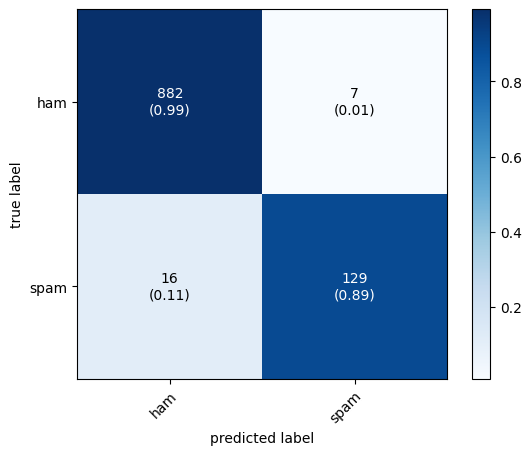

In [157]:
from mlxtend.plotting import plot_confusion_matrix
simplernn_cm = confusion_matrix(y_test, simplernn_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=simplernn_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["ham", "spam"])
plt.show()

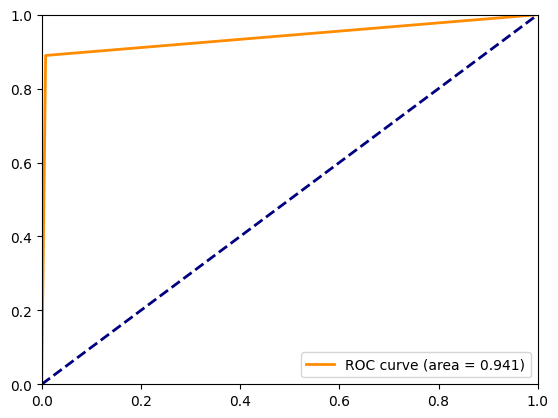

In [158]:
fpr, tpr, _ = roc_curve(y_test, simplernn_pred_test)
simplernn_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label = f"ROC curve (area = {simplernn_roc_auc :.3f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

In [159]:
#LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
import time
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN
from keras.layers import Dense, Activation, Dropout
from keras.layers import Embedding

from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix

In [160]:
lstm = Sequential([
    Input(shape = X_train_tokenizer.shape[1]),
    Embedding(len(tokenizer.word_index)+1, 32),
    LSTM(100),
    Dense(1, activation='sigmoid')
])

lstm.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

lstm.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 150, 32)           244608    
                                                                 
 lstm_3 (LSTM)               (None, 100)               53200     
                                                                 
 dense_10 (Dense)            (None, 1)                 101       
                                                                 
Total params: 297909 (1.14 MB)
Trainable params: 297909 (1.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [161]:
model2_train_start = time.time()
lstm_results = lstm.fit(X_train_tokenizer, y_train, epochs=4, batch_size=64,validation_split=0.1)
model2_train_end = time.time()
model2_train_time = model2_train_end - model2_train_start
print("Model2 Train Time = ", model2_train_time)

Epoch 1/4
59/59 [==============================] - 9s 121ms/step - loss: 0.3665 - accuracy: 0.8775 - val_loss: 0.1413 - val_accuracy: 0.9348
Epoch 2/4
59/59 [==============================] - 4s 63ms/step - loss: 0.1082 - accuracy: 0.9729 - val_loss: 0.0551 - val_accuracy: 0.9831
Epoch 3/4
59/59 [==============================] - 2s 38ms/step - loss: 0.0410 - accuracy: 0.9884 - val_loss: 0.0558 - val_accuracy: 0.9783
Epoch 4/4
59/59 [==============================] - 2s 32ms/step - loss: 0.0229 - accuracy: 0.9925 - val_loss: 0.0545 - val_accuracy: 0.9855
Model2 Train Time =  22.23063635826111


In [162]:
model2_test_start = time.time()
lstm_pred_test = lstm.predict(X_test_tokenizer)
model2_test_end = time.time()
model2_test_time = model2_test_end - model2_test_start
print("Model2 Test Time = ", model2_test_time)

33/33 [==============================] - 1s 5ms/step
Model2 Test Time =  0.5773813724517822


In [163]:
lstm_pred_train = lstm.predict(X_train_tokenizer)
lstm_pred_train = [1 if i > 0.5 else 0 for i in lstm_pred_train]
lstm_pred_test = [1 if i > 0.5 else 0 for i in lstm_pred_test]
lstm_train_score = accuracy_score(lstm_pred_train, y_train)
lstm_test_score = accuracy_score(lstm_pred_test, y_test)
print(f"LSTM Train Score = {lstm_train_score * 100:.2f}%")
print(f"LSTM Test Score = {lstm_test_score * 100:.2f}%")

130/130 [==============================] - 1s 4ms/step
LSTM Train Score = 99.32%
LSTM Test Score = 97.97%


In [164]:
lstm_precision_score = precision_score(y_test, lstm_pred_test)
lstm_f1_score = f1_score(y_test, lstm_pred_test)
lstm_recall_score = recall_score(y_test, lstm_pred_test)
lstm_accuracy_score = accuracy_score(y_test, lstm_pred_test)

print(f"LSTM Precision Score = {lstm_precision_score * 100:.2f}%")
print(f"LSTM F1 Score = {lstm_f1_score * 100:.2f}%")
print(f"LSTM Recall Score = {lstm_recall_score * 100:.2f}%")
print(f"LSTM Accuracy Score = {lstm_accuracy_score * 100:.2f}%")

LSTM Precision Score = 97.69%
LSTM F1 Score = 92.36%
LSTM Recall Score = 87.59%
LSTM Accuracy Score = 97.97%


In [165]:
print(classification_report(y_test, lstm_pred_test, target_names=["ham", "spam"]))

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       889
        spam       0.98      0.88      0.92       145

    accuracy                           0.98      1034
   macro avg       0.98      0.94      0.96      1034
weighted avg       0.98      0.98      0.98      1034



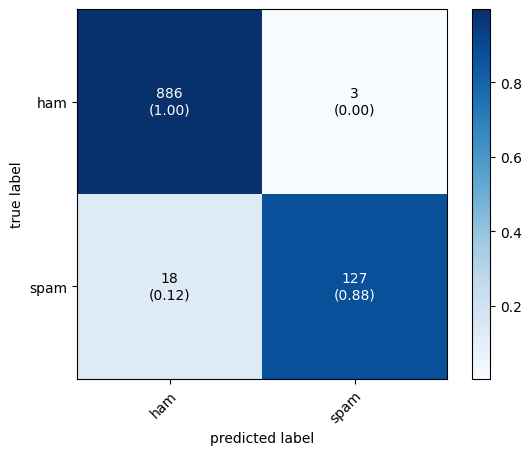

In [166]:
lstm_cm = confusion_matrix(y_test, lstm_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=lstm_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["ham", "spam"])
plt.show()

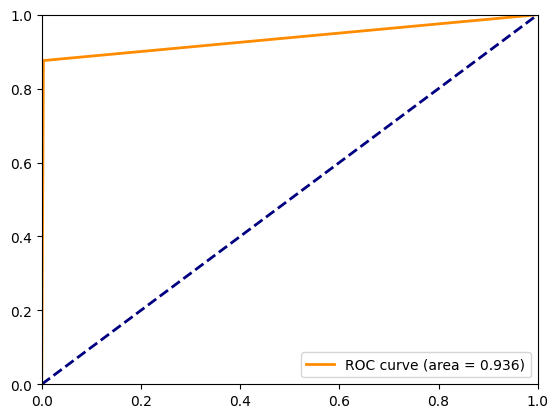

In [167]:
fpr, tpr, _ = roc_curve(y_test, lstm_pred_test)
lstm_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {lstm_roc_auc :.3f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

In [168]:
#GRU
gru = Sequential([
    Input(shape=X_train_tokenizer.shape[1]),
    Embedding(len(tokenizer.word_index)+1, 32),
    GRU(100),
    Dense(1, activation='sigmoid')
])

gru.compile(loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

gru.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 150, 32)           244608    
                                                                 
 gru_3 (GRU)                 (None, 100)               40200     
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                                 
Total params: 284909 (1.09 MB)
Trainable params: 284909 (1.09 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [169]:
model3_train_start = time.time()
gru_results = gru.fit(X_train_tokenizer, y_train, epochs=4, batch_size=64, validation_split=0.1)
model3_train_end = time.time()
model3_train_time = model3_train_end - model3_train_start
print("Model3 Train Time = ", model3_train_time)

Epoch 1/4
59/59 [==============================] - 9s 111ms/step - loss: 0.3569 - accuracy: 0.8761 - val_loss: 0.1149 - val_accuracy: 0.9662
Epoch 2/4
59/59 [==============================] - 4s 74ms/step - loss: 0.0819 - accuracy: 0.9798 - val_loss: 0.0537 - val_accuracy: 0.9807
Epoch 3/4
59/59 [==============================] - 2s 32ms/step - loss: 0.0328 - accuracy: 0.9922 - val_loss: 0.0474 - val_accuracy: 0.9758
Epoch 4/4
59/59 [==============================] - 2s 43ms/step - loss: 0.0168 - accuracy: 0.9954 - val_loss: 0.0528 - val_accuracy: 0.9758
Model3 Train Time =  17.694552421569824


In [170]:
model3_test_start = time.time()
gru_pred_test = gru.predict(X_test_tokenizer)
model3_test_end = time.time()
model3_test_time = model3_test_end - model3_test_start
print("Model3 Test Time = ", model3_test_time)

33/33 [==============================] - 0s 5ms/step
Model3 Test Time =  0.5367357730865479


In [171]:
gru_pred_train = gru.predict(X_train_tokenizer)
gru_pred_train = [1 if i > 0.5 else 0 for i in gru_pred_train]
gru_pred_test = [1 if i > 0.5 else 0 for i in gru_pred_test]
gru_train_score = accuracy_score(gru_pred_train, y_train)
gru_test_score = accuracy_score(gru_pred_test, y_test)
print(f"GRU Train Score = {gru_train_score * 100:.2f}%")
print(f"GRU Test Score = {gru_test_score * 100:.2f}%")

130/130 [==============================] - 1s 4ms/step
GRU Train Score = 99.40%
GRU Test Score = 97.78%


In [172]:
gru_precision_score = precision_score(y_test, gru_pred_test)
gru_f1_score = f1_score(y_test, gru_pred_test)
gru_recall_score = recall_score(y_test, gru_pred_test)
gru_accuracy_score = accuracy_score(y_test, gru_pred_test)

print(f"GRU Precision Score = {gru_precision_score * 100:.2f}%")
print(f"GRU F1 Score = {gru_f1_score * 100:.2f}%")
print(f"GRU Recall Score = {gru_recall_score * 100:.2f}%")
print(f"GRU Accuracy Score = {gru_accuracy_score * 100:.2f}%")

GRU Precision Score = 95.52%
GRU F1 Score = 91.76%
GRU Recall Score = 88.28%
GRU Accuracy Score = 97.78%


In [173]:
print(classification_report(y_test, gru_pred_test, target_names=["ham", "spam"]))

              precision    recall  f1-score   support

         ham       0.98      0.99      0.99       889
        spam       0.96      0.88      0.92       145

    accuracy                           0.98      1034
   macro avg       0.97      0.94      0.95      1034
weighted avg       0.98      0.98      0.98      1034



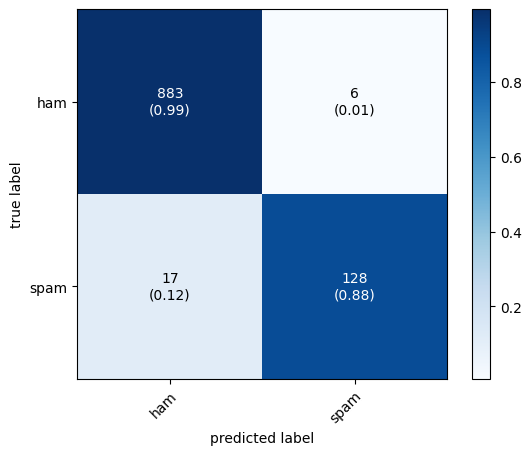

In [174]:
gru_cm = confusion_matrix(y_test, gru_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=gru_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["ham", "spam"])
plt.show()

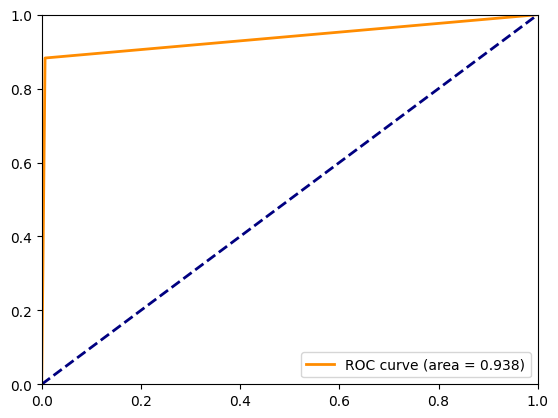

In [175]:
fpr, tpr, _ = roc_curve(y_test, gru_pred_test)
gru_roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {gru_roc_auc :.3f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.legend(loc="lower right")

In [176]:
scores_mail = pd.DataFrame(columns=["Model Name", "Train Time", "Test Time", "Train Score", "Test Score",
                                  "Accuracy", "F1", "Precision", "Recall", "ROC-AUC"])

In [177]:
scores_mail.loc[1] = ["SimpleRNN",
                    model1_train_time,
                    model1_test_time,
                    simplernn_train_score,
                    simplernn_test_score,
                    simplernn_accuracy_score,
                    simplernn_f1_score,
                    simplernn_precision_score,
                    simplernn_recall_score,
                    simplernn_roc_auc]

In [178]:
scores_mail.loc[2] = ["LSTM",
                    model2_train_time,
                    model2_test_time,
                    lstm_train_score,
                    lstm_test_score,
                    lstm_accuracy_score,
                    lstm_f1_score,
                    lstm_precision_score,
                    lstm_recall_score,
                    lstm_roc_auc]

In [179]:
scores_mail.loc[3] = ["GRU",
                    model3_train_time,
                    model3_test_time,
                    gru_train_score,
                    gru_test_score,
                    gru_accuracy_score,
                    gru_f1_score,
                    gru_precision_score,
                    gru_recall_score,
                    gru_roc_auc]

In [180]:
scores_mail

,Model Name,Train Time,Test Time,Train Score,Test Score,Accuracy,F1,Precision,Recall,ROC-AUC
1,SimpleRNN,47.115975,0.780512,0.993954,0.977756,0.977756,0.918149,0.948529,0.889655,0.940891
2,LSTM,22.230636,0.577381,0.993229,0.979691,0.979691,0.923636,0.976923,0.875862,0.936244
3,GRU,17.694552,0.536736,0.993954,0.977756,0.977756,0.917563,0.955224,0.882759,0.938005
